<a href="https://colab.research.google.com/github/kuir-juach/sentiment_anaysis_Group8/blob/main/sentiment_analysis_dl_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Uninstall existing versions of gensim and numpy
!pip uninstall -y gensim numpy

# Reinstall gensim and numpy cleanly
!pip install --no-cache-dir gensim numpy

!pip install wordcloud textblob

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 232.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 250.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 199.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 227.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfully uninstalled scipy-1.15.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import re
from textblob import TextBlob
from nltk.tokenize import word_tokenize
import gensim.downloader as api
from gensim.models import KeyedVectors

In [2]:
# File paths
json_path = '/content/drive/MyDrive/2025-02/yelp_academic_dataset_review.json'
csv_path = '/content/drive/MyDrive/2025-02/yelp_reviews_sample.csv'

# Read and save the first chunk (e.g. 100,000 rows)
# chunk = pd.read_json(json_path, lines=True, chunksize=100000)
# first_chunk = next(chunk)
# first_chunk.to_csv(csv_path, index=False)
first_chunk = pd.read_csv(csv_path)

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [4]:
df = first_chunk.head(6500).copy()

In [5]:
df.columns


Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')

In [6]:
print(df.describe())
print(df.isnull().sum())

             stars       useful        funny         cool
count  6500.000000  6500.000000  6500.000000  6500.000000
mean      3.850462     0.882462     0.258154     0.336923
std       1.350468     1.866535     0.948498     0.969463
min       1.000000     0.000000     0.000000     0.000000
25%       3.000000     0.000000     0.000000     0.000000
50%       4.000000     0.000000     0.000000     0.000000
75%       5.000000     1.000000     0.000000     0.000000
max       5.000000    61.000000    26.000000    13.000000
review_id      0
user_id        0
business_id    0
stars          0
useful         0
funny          0
cool           0
text           0
date           0
dtype: int64


In [7]:
df['date'] = pd.to_datetime(df['date'])

In [8]:
df['clean_text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x.lower()))

In [9]:
df['label'] = df['stars'].apply(lambda x: 1 if x >= 4 else 0)

In [10]:
df.head(1)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,clean_text,label
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,if you decide to eat here just be aware it is ...,0


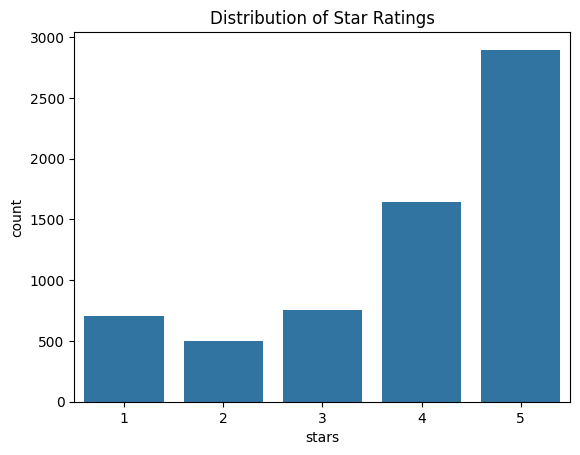

In [11]:
sns.countplot(x='stars', data=df)
plt.title('Distribution of Star Ratings')
plt.show()

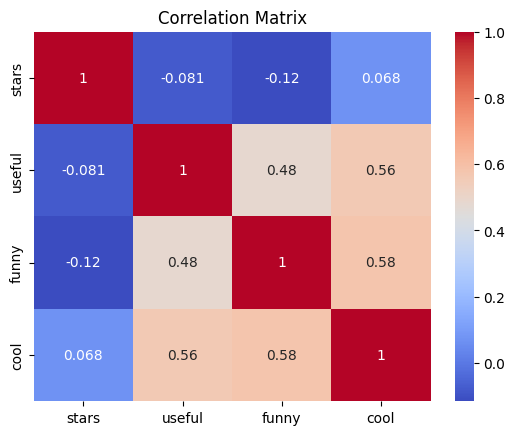

In [12]:
# Correlation matrix
correlation = df[['stars', 'useful', 'funny', 'cool']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

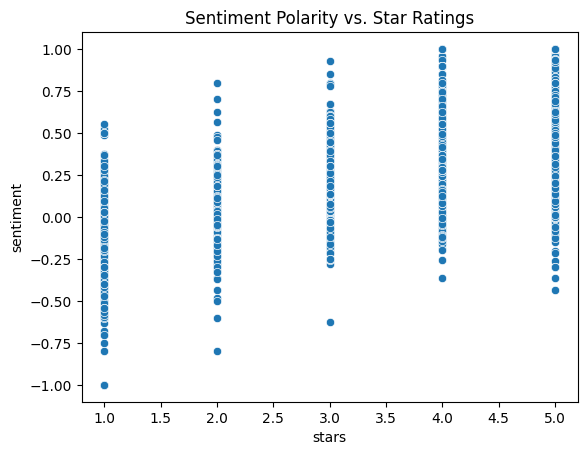

In [13]:
df['sentiment'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Plot sentiment vs. stars
sns.scatterplot(x='stars', y='sentiment', data=df)
plt.title('Sentiment Polarity vs. Star Ratings')
plt.show()

In [14]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

df['tokens'] = df['text'].apply(preprocess_text)

In [15]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,clean_text,label,sentiment,tokens
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,if you decide to eat here just be aware it is ...,0,0.085278,"[decide, eat, aware, going, take, hours, begin..."
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,ive taken a lot of spin classes over the years...,1,0.402273,"[ive, taken, lot, spin, classes, years, nothin..."
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,family diner had the buffet eclectic assortmen...,0,0.139935,"[family, diner, buffet, eclectic, assortment, ..."
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,wow yummy different delicious our favorite...,1,0.302557,"[wow, yummy, different, delicious, favorite, l..."
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,cute interior and owner gave us tour of upcom...,1,0.400969,"[cute, interior, owner, gave, us, tour, upcomi..."


In [16]:
def get_word2vec_model():
  word2vec_model = api.load('word2vec-google-news-300')

  return word2vec_model

In [17]:
def load_glove_embeddings(file_path, encoding='utf-8'):

    embeddings = {}
    embedding_dim = None

    with open(file_path, 'r', encoding=encoding) as f:
        for line_num, line in enumerate(f, 1):

            parts = line.strip().split()
            if len(parts) < 2:
                continue

            word = parts[0]
            vector = np.array([float(x) for x in parts[1:]], dtype=np.float32)

            # Set embedding dimension using first word
            if embedding_dim is None:
                embedding_dim = len(vector)

            # Inconsistent dimensions
            if len(vector) != embedding_dim:
                print(f"Warning: Skipping word '{word}' with inconsistent dimension")
                continue

            embeddings[word] = vector

    # Glove Model
    class GloVeModel:
        def __init__(self, embeddings):
            self.embeddings = embeddings
            self.key_to_index = {word: i for i, word in enumerate(embeddings.keys())}
            self.vector_size = embedding_dim

        def __contains__(self, word):
            return word in self.embeddings

        def __getitem__(self, word):
            if word not in self.embeddings:
                raise KeyError(f"Word '{word}' not found in embeddings")
            return self.embeddings[word]

        def get_vector(self, word):
            return self.embeddings[word]

    return GloVeModel(embeddings)


glove_model = load_glove_embeddings('/content/drive/MyDrive/2025-02/glove.6B.100d.txt')

if 'good' in glove_model:
    embedding = glove_model['good']
    print(f"Embedding shape: {embedding.shape}")

Embedding shape: (100,)


In [18]:
embedding_dim = 300
max_length = 100

In [19]:
# import numpy as np
# def get_review_embedding(tokens, model, embedding_dim=300):
#     valid_embeddings = [model[word] for word in tokens if word in model]
#     if len(valid_embeddings) == 0:
#         return np.zeros(embedding_dim)
#     return np.mean(valid_embeddings, axis=0)

# # Compute embeddings for each review
# df['embedding'] = df['tokens'].apply(lambda tokens: get_review_embedding(tokens, word2vec_model, embedding_dim=embedding_dim))

In [20]:
embedding_model = get_word2vec_model()

In [21]:
def embed_seq_for_lstm(tokens, model, max_length=100, embedding_dim=300):
    embeddings = np.zeros((max_length, embedding_dim))

    # Fill only the positions we have tokens for
    for i, word in enumerate(tokens[:max_length]):
        if word in model:
            embeddings[i] = model[word]
        # else: already zeros from initialization

    return embeddings

df['seq_embedding'] = df['tokens'].apply(lambda tokens: embed_seq_for_lstm(tokens, embedding_model, max_length=max_length, embedding_dim=embedding_dim))

In [22]:
df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,clean_text,label,sentiment,tokens,seq_embedding
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,if you decide to eat here just be aware it is ...,0,0.085278,"[decide, eat, aware, going, take, hours, begin...","[[0.09814453125, 0.09326171875, 0.16796875, 0...."
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,ive taken a lot of spin classes over the years...,1,0.402273,"[ive, taken, lot, spin, classes, years, nothin...","[[-0.412109375, 0.1884765625, -0.234375, 0.296..."
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,family diner had the buffet eclectic assortmen...,0,0.139935,"[family, diner, buffet, eclectic, assortment, ...","[[-0.018798828125, -0.1181640625, -0.143554687..."
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,wow yummy different delicious our favorite...,1,0.302557,"[wow, yummy, different, delicious, favorite, l...","[[0.125, 0.01806640625, 0.0576171875, 0.002273..."
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,cute interior and owner gave us tour of upcom...,1,0.400969,"[cute, interior, owner, gave, us, tour, upcomi...","[[0.10107421875, 0.049560546875, -0.1171875, 0..."


In [23]:
X = np.array(list(df['seq_embedding']))
y = df['label'].values

In [24]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verify the shapes
print(f'Training data shape: {X_train.shape}')
print(f'Testing data shape: {X_test.shape}')



Training data shape: (5200, 100, 300)
Testing data shape: (1300, 100, 300)


In [25]:
zero_vectors = np.sum(np.all(X == 0, axis=1))
print(f'Number of reviews with zero vectors: {zero_vectors}')

Number of reviews with zero vectors: 0


In [26]:
!pip install tensorflow

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input, GlobalAveragePooling1D, Dropout
from tensorflow.keras.optimizers import Adam, Nadam

def create_deep_learning_model(input_shape, lstm_units=64):
    """
    LSTM model for pre-computed embeddings
    """
    model = Sequential([
        Input(shape=input_shape), # 1
        Bidirectional(LSTM(lstm_units, return_sequences=True)), # 2
        Bidirectional(LSTM(lstm_units//2, return_sequences=True)), # 3
        GlobalAveragePooling1D(), # 4
        Dense(64, activation='relu'), # 5
        Dropout(0.3), # 6
        Dense(1, activation='sigmoid') # 7
    ])

    optimizer = Adam(learning_rate=0.0004)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', 'mae']
        )

    return model

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

input_shape = (max_length, embedding_dim)
model = create_deep_learning_model(input_shape=input_shape, lstm_units=64)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    callbacks=[early_stopping, reduce_lr],
    validation_split=0.2,
    verbose=1
)

Epoch 1/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 64s 397ms/step - accuracy: 0.6901 - loss: 0.6112 - mae: 0.4296 - val_accuracy: 0.8317 - val_loss: 0.3874 - val_mae: 0.2416 - learning_rate: 4.0000e-04
Epoch 2/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 74s 342ms/step - accuracy: 0.8293 - loss: 0.4090 - mae: 0.2556 - val_accuracy: 0.8673 - val_loss: 0.3241 - val_mae: 0.2131 - learning_rate: 4.0000e-04
Epoch 3/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 76s 300ms/step - accuracy: 0.8599 - loss: 0.3353 - mae: 0.2110 - val_accuracy: 0.8625 - val_loss: 0.3081 - val_mae: 0.2019 - learning_rate: 4.0000e-04
Epoch 4/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 40s 292ms/step - accuracy: 0.8773 - loss: 0.3117 - mae: 0.1877 - val_accuracy: 0.8731 - val_loss: 0.3018 - val_mae: 0.1987 - learning_rate: 4.0000e-04
Epoch 5/100
130/130 ━━━━━━━━━━━━━━━━━━━━ 43s 305ms/step - accuracy: 0.8732 - loss: 0.3251 - mae: 0.1943 - val_accuracy: 0.8625 - val_loss: 0.3161 - val_mae: 0.1863 - learning_rate: 4.0000e-04
Epoch 6/100
130/130 ━━━━━━━━━━━━━━━━━━━━

In [29]:
def evaluate_sentiment_model(model, X_test, y_test):
    """
    Comprehensive evaluation for sentiment regression
    """
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

    # Get predictions
    y_pred = model.predict(X_test, verbose=0).flatten()

    # Calculate regression metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)  # R-squared (coefficient of determination)
    correlation = np.corrcoef(y_test, y_pred)[0, 1]

    # Additional regression metrics
    mape = np.mean(np.abs((y_test - y_pred) / np.maximum(np.abs(y_test), 1e-8))) * 100

    print("="*50)
    print("SENTIMENT REGRESSION EVALUATION")
    print("="*50)
    print(f"MSE(loss):            {mse:.4f}")
    print(f"MAE:            {mae:.4f}")
    print(f"RMSE:           {rmse:.4f}")
    print(f"R²:             {r2:.4f}")
    print(f"Correlation:    {correlation:.4f}")
    print(f"MAPE:           {mape:.2f}%")
    print("="*50)

    return {
        'mse': mse, 'mae': mae, 'rmse': rmse,
        'r2': r2, 'correlation': correlation, 'mape': mape
    }

regression_results = evaluate_sentiment_model(model, X_test, y_test)

SENTIMENT REGRESSION EVALUATION
MSE(loss):            0.0994
MAE:            0.1811
RMSE:           0.3152
R²:             0.5404
Correlation:    0.7378
MAPE:           1045100356.11%


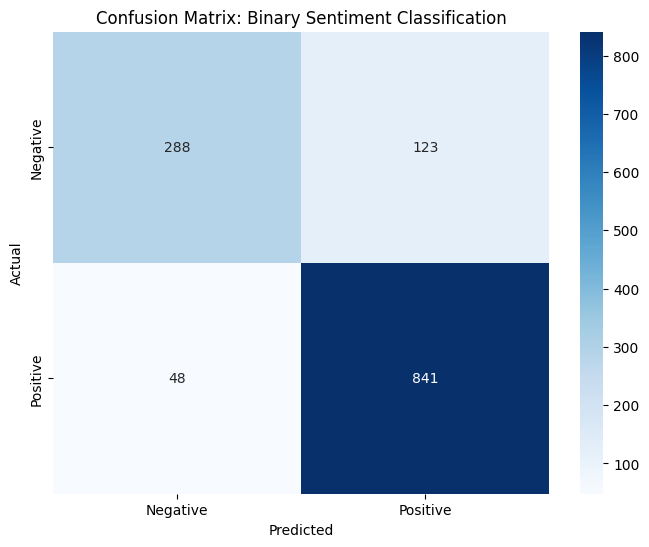


Confusion Matrix Breakdown:
True Negatives:  288
False Positives: 123
False Negatives: 48
True Positives:  841

Precision: 0.8724
Recall:    0.9460
F1-Score:  0.9077


In [30]:
def create_binary_confusion_matrix(model, X_test, y_test):
    """
    Create confusion matrix for binary classification
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sklearn.metrics import confusion_matrix

    # Get predictions
    y_pred_prob = model.predict(X_test, verbose=0).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix: Binary Sentiment Classification')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Extract metrics from confusion matrix
    tn, fp, fn, tp = cm.ravel()

    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * (precision * recall) / (precision + recall)

    print("\nConfusion Matrix Breakdown:")
    print(f"True Negatives:  {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives:  {tp}")
    print(f"\nPrecision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")

    return cm

# Usage
cm = create_binary_confusion_matrix(model, X_test, y_test)

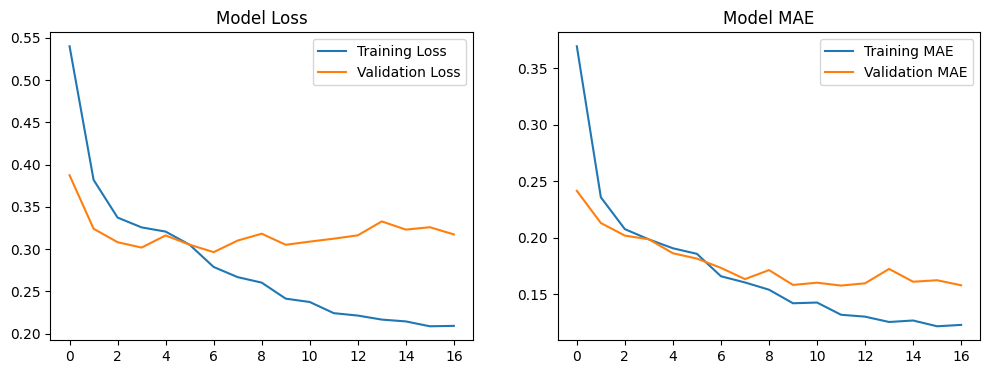

In [31]:
# Optional: Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.legend()
plt.show()